In [1]:
import numpy as np
from netCDF4 import Dataset
import datetime
import glob
import os
from matplotlib.ticker import FormatStrFormatter
import matplotlib.pyplot as plt
import cartopy
from matplotlib import gridspec
from regrid import regrid
import itertools
import cartopy.crs as ccrs
import tqdm
from scipy.stats import linregress
import warnings
warnings.filterwarnings("ignore")

/opt/anaconda3/envs/phd/lib/python3.8/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


In [2]:
datapath = '/Users/carmennab/Dropbox/met_office/data/experiments/FOAM_grid/'
ctrl = Dataset(datapath+'rosie_UCL_CTL_NOSIT_ASSIM_r243541_dcarneir.nc')
base = Dataset(datapath+'rosie_UCL_BASELINE_SIT_ASSIM_CS2_AWI_SNFOAM_ALPHA1_r243541_dcarneir.nc')
unc = Dataset(datapath+'rosie_UCL_SIT_ASSIM_CS2_AWI_SNFOAM_ALPHA1_NEW_OBERR_r243541_dcarneir.nc')
### alpha
nine = Dataset(datapath+'rosie_UCL_SIT_ASSIM_CS2_AWI_SNFOAM_ALPHA09_r243541_dcarneir.nc')
six = Dataset(datapath+'rosie_UCL_SIT_ASSIM_CS2_AWI_SNFOAM_ALPHA06_r243541_dcarneir.nc')
### retracker
larm = Dataset(datapath+'rosie_UCL_SIT_ASSIM_CS2_BRISTOL_SNFOAM_ALPHA1_r243541_dcarneir.nc')
cpom = Dataset(datapath+'rosie_UCL_SIT_ASSIM_CS2_CPOM_SNFOAM_ALPHA1_r243541_dcarneir.nc')
### snow
smlg = Dataset(datapath+'rosie_UCL_SIT_ASSIM_CS2_AWI_SNLG_ALPHA1_r243541_dcarneir.nc')
awi = Dataset(datapath+'rosie_UCL_SIT_ASSIM_CS2_AWI_SNAWI_ALPHA1_r243541_dcarneir.nc')

In [3]:
rho_fyi = 916.7
rho_myi = 882
icetype = np.array(Dataset('/Users/carmennab/Dropbox/met_office/data/auxiliary/icetype.nc')['Ice Type'])
icetype[icetype==2] = rho_fyi
icetype[icetype==3] = rho_myi

In [4]:
foam_lats = np.load('/Users/carmennab/Dropbox/met_office/data/auxiliary/lat_cent.npy')
foam_lons = np.load('/Users/carmennab/Dropbox/met_office/data/auxiliary/lon_cent.npy')

sits = [ctrl,base,nine,six,larm,cpom,smlg,awi,unc]

names = ['CTRL','BASE','\u03B1_0.9', '\u03B1_0.6','FB_LARM','FB_CPOM','SN_SMLG','SN_AWI','UNC']

In [6]:
thicks = {}
for name, sit in zip(names,sits):
    rate = np.array(sit['sidmassth']) # sea-ice mass change from thermodynamics kg/m2/s
    
    dens = icetype.copy() 
    thick = rate / dens # thickness change in m3/m2/s 
    thick_day = thick * 86400 # convert from rate per second to thickness per day m3/m2/day = m/day

    thicks[name] = thick_day

In [ ]:
means = {}

for name in names:
    means[name] = np.nanmean(thicks[name],axis=0) * 100
    
stdevs = []
for name in names[1:]:
    stdevs.append(means[name])
means['STDEV'] = np.std(stdevs,axis=0)

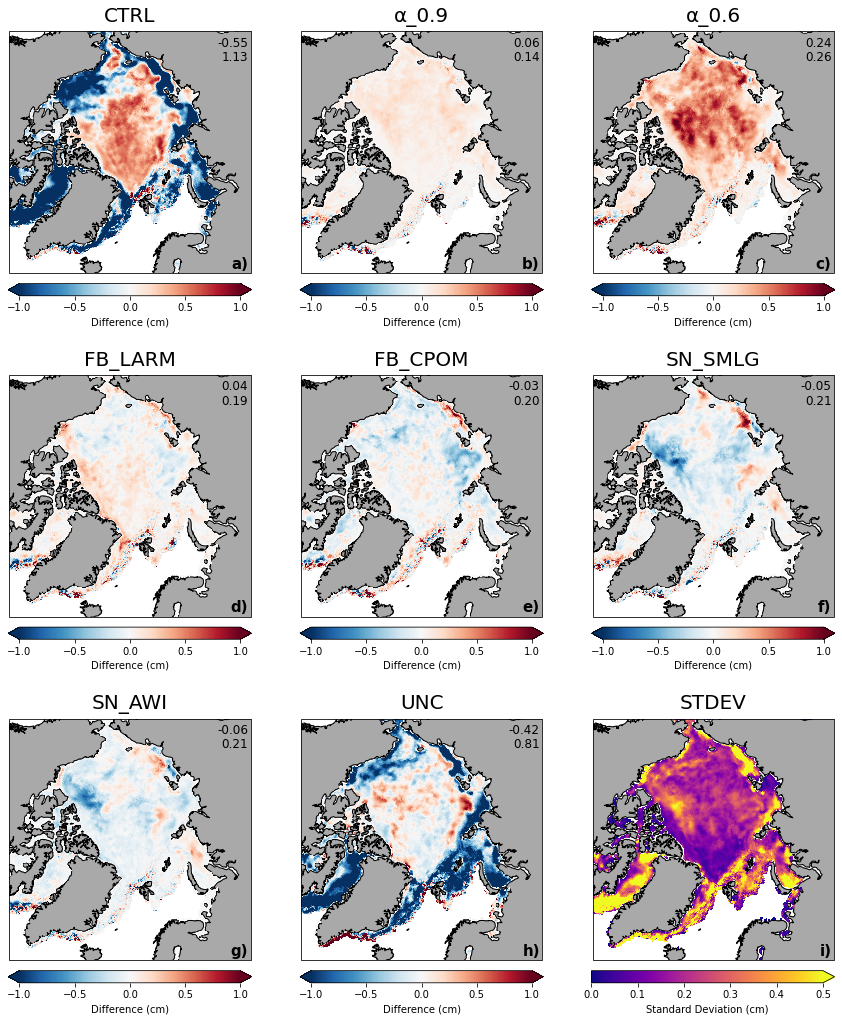

In [8]:
fig = plt.figure(figsize=(15,17.5))
spec = gridspec.GridSpec(ncols=3, nrows=3, hspace=0.3, wspace=0.15)

names = ['CTRL','\u03B1_0.9', '\u03B1_0.6','FB_LARM','FB_CPOM','SN_SMLG','SN_AWI','UNC','STDEV']
nums = ['a)','b)','c)','d)','e)','f)','g)','h)','i)']

for count, name in enumerate(names):
    ax = fig.add_subplot(spec[count],projection=ccrs.NorthPolarStereo())
    ax.set_extent([-180, 180, 90, 65], ccrs.PlateCarree())
    ax.add_feature(cartopy.feature.LAND, color='darkgrey',zorder=1)
    ax.coastlines()
    ax.set_title(name, fontsize=20, pad=10)  
    if count == 8:
        p_map = ax.pcolormesh(foam_lons,foam_lats,means[name][:-1,:-1],vmin=0,vmax=0.5,cmap='plasma',
                              transform=ccrs.PlateCarree()) 
        a = plt.colorbar(p_map,location="bottom",fraction=0.046, pad=0.04,extend='max') 
        a.set_label('Standard Deviation (cm)',fontsize='medium')  
    else:
        p_map = ax.pcolormesh(foam_lons,foam_lats,(means[name][:-1,:-1]-means['BASE'][:-1,:-1]),cmap='RdBu_r',
                              vmin=-1,vmax=1,transform=ccrs.PlateCarree())
        ax.text(0.99, 0.94, f"{np.round(np.nanmean(means[name]-means['BASE']),decimals=2):.2f}", fontsize=12,
                ha= 'right', transform = ax.transAxes)    
        ax.text(0.99, 0.88, f"{np.round(np.nanstd(means[name]-means['BASE']),decimals=2):.2f}", fontsize=12,
                ha= 'right', transform = ax.transAxes)
        cbar = plt.colorbar(p_map,location="bottom",fraction=0.046, pad=0.04, extend = 'both') 
        cbar.set_label('Difference (cm)',fontsize='medium')  
    ax.text(0.99, 0.02, nums[count], fontsize=15, ha= 'right', transform = ax.transAxes,fontweight='bold')
    
plt.savefig('/Users/carmennab/Dropbox/Apps/Overleaf/FOAM sensitivity/main_figs/tmc_maps_effective.png',dpi=400, 
bbox_inches="tight")